In [ ]:
import ee, geemap
import numpy as np
import pandas as pd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
from datetime import datetime
from google.colab import userdata

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project=userdata.get('ProjectID'))

In [ ]:
csv_file_path = '/content/MOD13_MOD12_Malaysia.csv'
df = pd.read_csv(csv_file_path)

df.head()

,system:index,EVI,LC_Type1,NDVI,sur_refl_b01,sur_refl_b02,sur_refl_b03,sur_refl_b07,year,.geo
0,0_1,5066.478261,2,7938.782609,384.695652,3194.913043,244.782609,623.913043,2001,"{""type"":""Point"",""coordinates"":[100.21574980221..."
1,0_4,4860.391304,2,7648.782609,503.086957,3260.652174,450.521739,597.739130,2001,"{""type"":""Point"",""coordinates"":[117.64568409548..."
2,0_8,4815.304348,2,7284.086957,596.086957,3334.260870,506.695652,648.739130,2001,"{""type"":""Point"",""coordinates"":[114.55135717989..."
3,0_16,4195.391304,14,6236.652174,739.260870,3064.000000,481.391304,833.826087,2001,"{""type"":""Point"",""coordinates"":[102.43291792862..."
4,0_18,6227.826087,2,8475.826087,336.304348,3891.217391,261.913043,636.565217,2001,"{""type"":""Point"",""coordinates"":[101.20163310053..."


### Part A: Data Preprocessing

2. Data Cleaning

In [ ]:
df.shape

(41546, 10)

In [ ]:
df.isna().sum()

,0
system:index,0
EVI,0
LC_Type1,0
NDVI,0
sur_refl_b01,0
sur_refl_b02,0
sur_refl_b03,0
sur_refl_b07,0
year,0
.geo,0


In [ ]:
df['EVI'] = df['EVI'] / 10000   # MODIS scaled integer -> actual EVI value
df['NDVI'] = df['NDVI'] / 10000  # MODIS scaled integer -> actual NDVI value


2.2 Remove Duplicates

In [ ]:
df = df.drop_duplicates()

1.3 Handle Outliers

In [ ]:
# Using IQR to handle outlier
Q1 = df[['NDVI', 'EVI']].quantile(0.25)
Q3 = df[['NDVI', 'EVI']].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = ((df[['NDVI', 'EVI']] < lower_bound) | (df[['NDVI', 'EVI']] > upper_bound)).any(axis=1)
df = df[~outlier_mask]  # Keep only non-outlier rows

print(f"DataFrame shape after IQR outlier removal: {df.shape}")
print(f"Number of rows removed: {outlier_mask.sum()}")

DataFrame shape after IQR outlier removal: (39021, 10)
Number of rows removed: 2525


### Step 2: Data Transformation

In [ ]:
# Group MODIS Land Cover (17 classes) into simplified categories
def group_lc(lc):
    # Forests
    if lc in [1, 2, 3, 4]:
        return 'Forest'
    # Agriculture
    elif lc in [5, 6]:
        return 'Agriculture'
    # Urban
    elif lc == 13:
        return 'Urban'
    #Wetland
    elif lc in [0, 15]:
        return 'Wetland'
    else:
    # Other
        return 'Other'

df['LC_group'] = df['LC_Type1'].apply(group_lc)

In [ ]:
display(df['LC_group'].value_counts())

,count
LC_group,
Forest,27975
Other,10770
Urban,274
Agriculture,2


2.2 Categorical Encoding

In [ ]:
# Create one-hot encoded columns for LC_group. This is for categorical features.
lc_encoded = pd.get_dummies(df['LC_group'], prefix='LC')
print(lc_encoded.head())

   LC_Agriculture  LC_Forest  LC_Other  LC_Urban
0           False       True     False     False
1           False       True     False     False
2           False       True     False     False
3           False      False      True     False
4           False       True     False     False


2.3 Feature Scaling

In [ ]:
# Using available numerical columns for scaling
features = df[['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b07']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

print("First 5 rows of StandardScaler transformation:\n", features_scaled[:5])

First 5 rows of StandardScaler transformation:
 [[-1.13147304 -0.33893243 -1.41206922 -0.49912747]
 [-0.54674033 -0.15911646 -0.34048754 -0.64752302]
 [-0.08741486  0.0422251  -0.0479086  -0.35837354]
 [ 0.61971875 -0.69701834 -0.179705    0.69099503]
 [-1.37047689  1.56566598 -1.32284623 -0.42739473]]


In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
lc_onehot_encoded = encoder.fit_transform(df[['LC_Type1']])

lc_onehot_df = pd.DataFrame(
    lc_onehot_encoded,
    columns=encoder.get_feature_names_out(['LC_Type1']),
    index=df.index
)
print(lc_onehot_df.head())

   LC_Type1_2  LC_Type1_4  LC_Type1_6  LC_Type1_8  LC_Type1_9  LC_Type1_10  \
0         1.0         0.0         0.0         0.0         0.0          0.0   
1         1.0         0.0         0.0         0.0         0.0          0.0   
2         1.0         0.0         0.0         0.0         0.0          0.0   
3         0.0         0.0         0.0         0.0         0.0          0.0   
4         1.0         0.0         0.0         0.0         0.0          0.0   

   LC_Type1_11  LC_Type1_12  LC_Type1_13  LC_Type1_14  LC_Type1_17  
0          0.0          0.0          0.0          0.0          0.0  
1          0.0          0.0          0.0          0.0          0.0  
2          0.0          0.0          0.0          0.0          0.0  
3          0.0          0.0          0.0          1.0          0.0  
4          0.0          0.0          0.0          0.0          0.0  


Feature Engineering

In [ ]:
import json

# Extract longitude and latitude from the .geo column
def extract_coordinates(geo_json_str):
    try:
        geo_data = json.loads(geo_json_str)
        if geo_data['type'] == 'Point' and 'coordinates' in geo_data:
            return geo_data['coordinates'][0], geo_data['coordinates'][1]
    except (json.JSONDecodeError, KeyError):
        pass
    return None, None

df['longitude'], df['latitude'] = zip(*df['.geo'].apply(extract_coordinates))

# Drop rows where coordinate extraction failed
df = df.dropna(subset=['longitude', 'latitude'])

# Sort for temporal lag creation
df = df.sort_values(['longitude','latitude','year'])

# Lag features: EVI from previous 1 and 2 years
df['EVI_lag1'] = df.groupby(['longitude','latitude'])['EVI'].shift(1)
df['EVI_lag2'] = df.groupby(['longitude','latitude'])['EVI'].shift(2)

# Drop rows with NaN after creating lag features
df = df.dropna(subset=['EVI_lag1','EVI_lag2'])

# Final results
print(df[['longitude', 'latitude', 'year', 'EVI', 'EVI_lag1', 'EVI_lag2']].head(10))

       longitude  latitude  year       EVI  EVI_lag1  EVI_lag2
3654    99.62692  1.533833  2003  0.406609  0.382678  0.352413
5477    99.62692  1.533833  2004  0.399948  0.406609  0.382678
7302    99.62692  1.533833  2005  0.427657  0.399948  0.406609
9126    99.62692  1.533833  2006  0.433148  0.427657  0.399948
10952   99.62692  1.533833  2007  0.453857  0.433148  0.427657
12747   99.62692  1.533833  2008  0.425004  0.453857  0.433148
14569   99.62692  1.533833  2009  0.428743  0.425004  0.453857
16394   99.62692  1.533833  2010  0.491717  0.428743  0.425004
18220   99.62692  1.533833  2011  0.495826  0.491717  0.428743
20042   99.62692  1.533833  2012  0.493617  0.495826  0.491717


### Step 3: Data Reduction

3.1 Dimensionality Reduction using PCA

In [ ]:
# Select features
features = df[['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b07']]

# Standardize the features
X_scaled = StandardScaler().fit_transform(features)

# Perform PCA with 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print("\nPrincipal Component Loadings:\n")

# Get loadings (feature contributions)
loadings = pd.DataFrame(
    pca.components_.T,
    index=features.columns,
    columns=[f'PC{i+1}' for i in range(3)]
)

print(loadings.round(3))

# Explained variance
explained_variance_ratio = pca.explained_variance_ratio_

print("\nExplained Variance Ratio:")
for i, var in enumerate(explained_variance_ratio, 1):
    print(f"PC{i}: {var:.3%}")

print("\nTop Features For Each Principle Component:")

for i, pc in enumerate(loadings.columns):
    print(f"\n{pc} (Variance: {explained_variance_ratio[i]:.2%}):")
    pc_loadings = loadings[pc].abs().sort_values(ascending=False)

    for feature in pc_loadings.index:
        value = loadings.loc[feature, pc]
        mark = "✓" if abs(value) > 0.5 else " "
        sign = "+" if value > 0 else "-"
        print(f"  {mark} {feature}: {sign}{abs(value):.3f}")

# Final PCA dataset
df_pca_3 = pd.DataFrame(
    X_pca,
    columns=[f'PC{i+1}' for i in range(3)],
    index=df.index
)

print("\nFirst 5 PCA-transformed rows:")
print(df_pca_3.head().round(4))



Principal Component Loadings:

                PC1    PC2    PC3
sur_refl_b01  0.624 -0.148 -0.124
sur_refl_b02  0.100  0.904 -0.414
sur_refl_b03  0.577 -0.266 -0.479
sur_refl_b07  0.517  0.300  0.764

Explained Variance Ratio:
PC1: 60.047%
PC2: 27.542%
PC3: 10.925%

Top Features For Each Principle Component:

PC1 (Variance: 60.05%):
  ✓ sur_refl_b01: +0.624
  ✓ sur_refl_b03: +0.577
  ✓ sur_refl_b07: +0.517
    sur_refl_b02: +0.100

PC2 (Variance: 27.54%):
  ✓ sur_refl_b02: +0.904
    sur_refl_b07: +0.300
    sur_refl_b03: -0.266
    sur_refl_b01: -0.148

PC3 (Variance: 10.93%):
  ✓ sur_refl_b07: +0.764
    sur_refl_b03: -0.479
    sur_refl_b02: -0.414
    sur_refl_b01: -0.124

First 5 PCA-transformed rows:
          PC1     PC2     PC3
3654   2.0788  0.3631  1.5785
5477   1.9881  0.1414  1.5062
7302   0.8251  0.1113  1.7128
9126   0.5702  0.2251  1.7728
10952 -0.1733  0.2289  1.5965


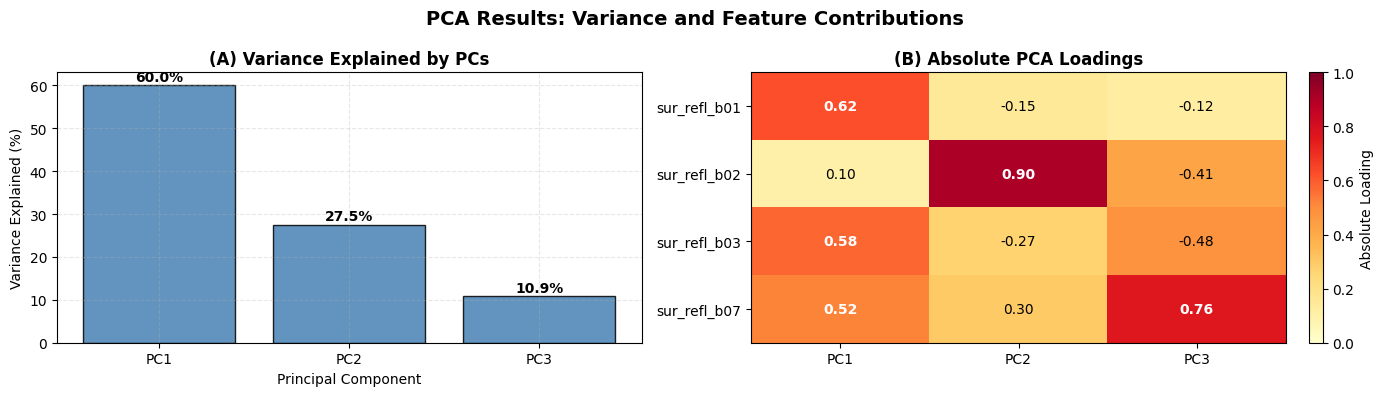

In [ ]:
# Select and scale features
features = df[['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b07']]
X_scaled = StandardScaler().fit_transform(features)

# PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# PCA statistics
explained_variance = pca.explained_variance_ratio_
loadings = pca.components_.T

# ================= FIGURE: 2 PLOTS IN 1 ROW =================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# ===== (A) SCREE / VARIANCE PLOT =====
components = ['PC1', 'PC2', 'PC3']
bars = ax1.bar(components, explained_variance * 100,
               color='steelblue', edgecolor='black', alpha=0.85)

ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Variance Explained (%)')
ax1.set_title('(A) Variance Explained by PCs', fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.3)

# Add labels
for bar, var in zip(bars, explained_variance):
    ax1.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 1,
             f'{var:.1%}', ha='center', fontsize=10, fontweight='bold')

# ===== (B) LOADINGS HEATMAP =====
im = ax2.imshow(np.abs(loadings), cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)

band_names = ['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b07']
ax2.set_xticks(range(3))
ax2.set_xticklabels(['PC1', 'PC2', 'PC3'])
ax2.set_yticks(range(4))
ax2.set_yticklabels(band_names)
ax2.set_title('(B) Absolute PCA Loadings', fontweight='bold')

# Annotate loadings
for i in range(loadings.shape[0]):
    for j in range(loadings.shape[1]):
        val = loadings[i, j]
        ax2.text(j, i, f'{val:.2f}',
                 ha='center', va='center',
                 color='white' if abs(val) > 0.5 else 'black',
                 fontweight='bold' if abs(val) > 0.5 else 'normal')

# Colorbar
cbar = plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
cbar.set_label('Absolute Loading')

# Overall title
plt.suptitle('PCA Results: Variance and Feature Contributions',
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


Final Dataset (PCA + One-Hot LC)

In [ ]:
df_final = pd.concat([df_pca, lc_encoded], axis=1)
df_final.head()


,PC1,PC2,PC3,LC_Agriculture,LC_Forest,LC_Other,LC_Urban
14569,-0.844270,-0.211069,1.084094,False,False,True,False
16394,0.460899,0.376028,1.288712,False,False,True,False
18220,0.355493,0.558233,0.981928,False,False,True,False
20042,0.837875,-0.371340,0.915466,False,False,True,False
21825,0.676112,0.151865,0.798558,False,False,True,False
